# Kalman Filter (Numpyro) - Object Tracking

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple
from jax.random import multivariate_normal, split
from tqdm.notebook import tqdm, trange
from jax.random import multivariate_normal
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
import jaxkf._src.lgssm as lgssm


import matplotlib.pyplot as plt

## Simulating Data

### State Transition Dynamics

We assume that we can fully describe the state when we have the `(x,y)` coordinates of the position and the `(x,y)` velocity. So we can write this as:

$$
\mathbf{z}_t = 
\begin{bmatrix}
z_t^1 \\ z_t^2 \\ \dot{z}_t^1 \\ \dot{z}_t^2
\end{bmatrix}
$$


where $z_t^d$ is the coordinate of the position and $\dot{z}^d$ is the velocity. 

We can describe the dynamics of the system using the following system of equations:

$$
\begin{aligned}
z_t^1 &= z_{t-1}^1 + \Delta_t \dot{z}_t^1 + \epsilon_t^1 \\
z_t^2 &= z_{t-1}^2 + \Delta_t \dot{z}_t^2 + \epsilon_t^2 \\
\dot{z}_t^1 &= \dot{z}_{t-1}^1 + \epsilon_t^3 \\
\dot{z}_t^2 &= \dot{z}_{t-1}^2 + \epsilon_t^4 \\
\end{aligned}
$$

This is a very simple formulation which takes a first order approximation to the change in position based on speed and we also assume constant velocity. Note, we also include some noise because we assume that some of the dynamics are noisy, i.e. there are random acceleration and position changes in the model. 


We can also put this into matrix formulation like so:

$$
\mathbf{z}_t = \mathbf{A}_t \mathbf{z}_{t-1} + \boldsymbol{\epsilon}_t
$$

where:

$$
\mathbf{A}_t = 
\begin{bmatrix}
1 & 0 & \Delta_t & 0 \\
0 & 1 & 0 & \Delta_t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \;\; \mathbf{A}_t \in \mathbb{R}^{4\times 4}
$$


---
### Emissions Model

We can only fully observe the locations (not the velocities). So this will be a lower dimensional vector of size 2-D. The system of equations are as follows:

$$
\begin{aligned}
x_t^1 &= z_t^1 + \delta_t^1 \\
x_t^2 &= z_t^2 + \delta_t^2 \\
\end{aligned}
$$

This is a very simple model where we assume we can extract the direct positions (plus some noise) from the state.

We can write this in an abbreviated matrix formulation:

$$
\mathbf{x}_t = \mathbf{C}_t \mathbf{z}_t + \delta_t
$$

where:

$$
\mathbf{C}_t = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}, \;\; \mathbf{C}_t \in \mathbb{R}^{2 \times 4}
$$

## Model

In [3]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro import diagnostics, infer
from numpyro.contrib.control_flow import scan

In [4]:
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_prior, rng_key_infer, rng_key_posterior = jax.random.split(rng_key, 4)

```python
def gaussian_hmm(obs=None, time_steps: int=10):
    
    if obs is not None:
        time_steps = obs.shape[0]
        
    # transition model
    trans = numpyro.sample("trans", dist.Normal(0, 1))
    # trans = numpyro.param("trans", 0.1)
    
    # emission model
    emit = numpyro.sample("emi", dist.Normal(0, 1))
    # emit = numpyro.param("emit", 0.1 )
    
    def body(z_prev, x_prev):
        # transition distribution
        z = numpyro.sample("z", dist.Normal(trans * z_prev, 1))
        
        # emission distribution
        x = numpyro.sample("x", dist.Normal(emit * z, 1), obs=x_prev)
        
        return z, (z, x)
    
    # prior dist
    z0 = numpyro.sample("z0", dist.Normal(0, 1))
    
    # scan
    _, (z, x) = scan(body, z0, obs, length=time_steps)
    
    return (z, x)
```

In [266]:
def simulate_data(num_samples: int=1, time_steps: int=10, dt=0.1, r=0.5, seed=123):
    
    key = jax.random.PRNGKey(seed)
    
    # init prior dist
    mu0 = jnp.array([0., 0., 1., -1.])
    Sigma0 = jnp.eye(4)
    prior_dist = dist.MultivariateNormal(loc=mu0, covariance_matrix=Sigma0)
    
    
    # =================
    # transition model
    # =================
    trans_mat = jnp.eye(4) + dt * jnp.eye(4, k=2)
    a = jnp.array([[dt**3/3, dt**2/2], [dt**2/2, dt]])
    b = jnp.eye(2)
    transition_noise = jnp.kron(a,b)
    
    # =================
    # emission model
    # =================
    obs_mat = jnp.eye(2, M=4)
    
    obs_noise = r**2 * jnp.eye(2)
    
    
    # ==============
    # sample from prior
    key, key_prior = jax.random.split(key, 2)
    
    z_prev = prior_dist.sample(key=key_prior, sample_shape=(num_samples,))
    
    assert z_prev.shape == (num_samples, 4)
    
    # results
    states = {"state_true": [], "state_noise": [], "meas_noise": []}
    
    # loop through time steps
    for i_z_init in tqdm(z_prev):
        z_prev = i_z_init
        state_true, state_noise, meas_noise = [], [], []
        for t in trange(time_steps):
            
            

            key, key_trans, key_obs = jax.random.split(key, 3)

            # true state z = F z
            z_true = trans_mat @ z_prev

            assert z_true.shape == (4,)
            state_true.append(z_true[None,:])

            # simulate transition model
            # z = F z + eps
            temp_dist = dist.MultivariateNormal(covariance_matrix=transition_noise)
            noise = temp_dist.sample(key=key_trans, sample_shape=(1,))
            

            z_prev = z_true.squeeze() + noise.squeeze()
            assert z_prev.shape == (4,)
            state_noise.append(z_prev)

            # simulate transition model
            # x = H z + eps
            temp_dist = dist.MultivariateNormal(loc=jnp.zeros(2), covariance_matrix=obs_noise)
            noise = temp_dist.sample(key=key_trans)
            
            x_prev = obs_mat @ z_prev.squeeze() + noise.squeeze()
            assert x_prev.shape == (2,)
            meas_noise.append(x_prev)


        
        states["state_true"].append(jnp.vstack(state_true))
        states["state_noise"].append(jnp.vstack(state_noise))
        states["meas_noise"].append(jnp.vstack(meas_noise))
            
            
        break

    states["state_true"] = jnp.vstack(states["state_true"])
    states["state_noise"] = jnp.vstack(states["state_noise"])
    states["meas_noise"] = jnp.vstack(states["meas_noise"])
    
    
    return states

In [267]:
states = simulate_data(1, time_steps=100)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [268]:
states["meas_noise"].shape

(100, 2)

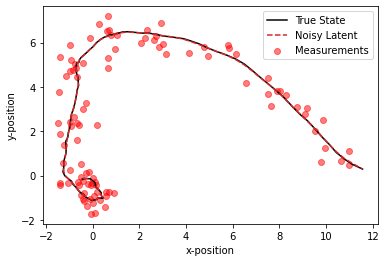

In [271]:
fig, ax = plt.subplots()

ax.plot(states["state_true"][..., 0], states["state_true"][..., 1], color="black", label="True State")
ax.plot(states["state_noise"][..., 0], states["state_noise"][..., 1], color="tab:red", linestyle="--", label="Noisy Latent")
ax.scatter(states["meas_noise"][..., 0], states["meas_noise"][..., 1], label="Measurements", color="red", alpha=0.5)

ax.set(xlabel="x-position", ylabel="y-position")
plt.legend()
plt.show()

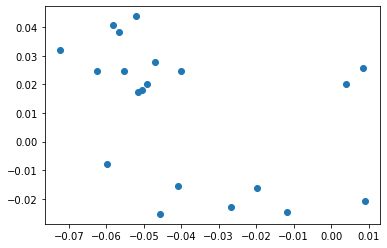

## Numpyro Model

In [5]:
dt = 0.1
r = 0.5

def gaussian_hmm(obs=None, time_steps: int=15):
    
    # extract shapes from observations
    if obs is not None:
        time_steps, obs_dim = obs.shape
    
    
    # =================
    # transition model
    # =================
    trans_mat = jnp.eye(4) + dt * jnp.eye(4, k=2)
    trans_mat = numpyro.deterministic("trans_mat",trans_mat)
    
    a = jnp.array([[dt**3/3, dt**2/2], [dt**2/2, dt]])
    b = jnp.eye(2)
    transition_noise = jnp.kron(a,b)
    
    # =================
    # emission model
    # =================
    obs_mat = jnp.eye(2, M=4)
    emission_mat = numpyro.deterministic("obs_mat", obs_mat)
    
    emission_noise = r**2 * jnp.eye(2)
    
    
    def body(z_prev, x_prev):
        
        # transition distribution
        z = trans_mat @ z_prev
        noise_z = numpyro.sample("trans_noise", dist.MultivariateNormal(covariance_matrix=transition_noise))
        
        z += noise_z
        
        z = numpyro.deterministic("z", z)
        
        # emission distribution
        x = emission_mat @ z
        
        noise_x = numpyro.sample("emiss_noise", dist.MultivariateNormal(covariance_matrix=emission_noise), obs=x_prev)
        
        x += noise_x
        
        x = numpyro.deterministic("x", x)
        
        return z, (z, x)
    
    # prior dist
    mu0 = jnp.array([0., 0., 1., -1.])
    Sigma0 = jnp.eye(4)
    z0 = numpyro.sample("z0", dist.MultivariateNormal(loc=mu0, covariance_matrix=Sigma0))
    
    # scan
    # with numpyro.handlers.condition(data={"x": x}):
    _, (z, x) = scan(body, z0, obs, length=time_steps)
    
    return (z, x)

### Observations

In [46]:
# obs = states["meas_noise"]
# T = obs.shape[0]
# D_obs = obs.shape[1]

In [47]:
# obs.shape

### Generative

In [48]:
with numpyro.handlers.seed(rng_seed=314):
    x, y = gaussian_hmm(None, time_steps=50)

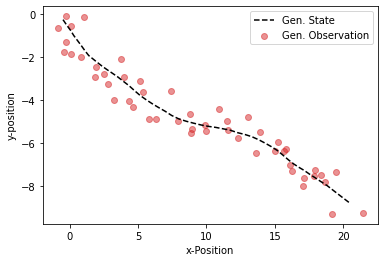

In [49]:
t_axes = jnp.arange(x.shape[0])

fig, ax = plt.subplots()

ax.plot(x[..., 0], x[..., 1], label="Gen. State", color="black", linestyle="--")
ax.scatter(y[..., 0], y[..., 1], label="Gen. Observation", color="tab:red", alpha=0.5)

ax.set(xlabel="x-Position", ylabel="y-position", )

plt.legend()
plt.show()

### Prior

In [50]:
%%time


# Prior prediction
predictive = infer.Predictive(gaussian_hmm, num_samples=100)

# without x
prior_predictive = predictive(rng_key_prior, time_steps=50)

# extract samples
x_samples = prior_predictive["x"]
z_samples = prior_predictive["z"]

CPU times: user 1.41 s, sys: 15.2 ms, total: 1.42 s
Wall time: 1.42 s


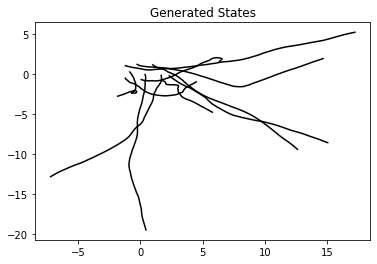

In [52]:
fig, ax = plt.subplots()

ax.plot(z_samples[:10,..., 0].T, z_samples[:10,..., 1].T, label="Gen. State", color="black", linestyle="-")
ax.set(title="Generated States")
plt.show()

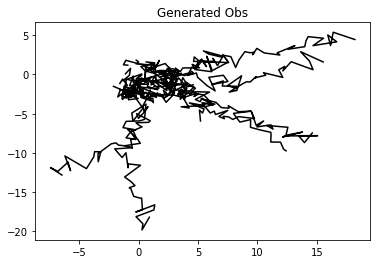

In [53]:
fig, ax = plt.subplots()

ax.plot(x_samples[:10,..., 0].T, x_samples[:10,..., 1].T, label="Gen. State", color="black", linestyle="-")
ax.set(title="Generated Obs")
plt.show()

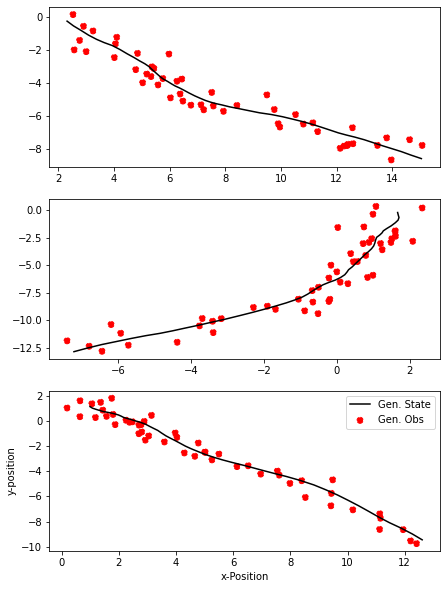

In [54]:
n_plots = 3
rand_int = 1

fig, axes = plt.subplots(nrows=3, figsize=(7, 10))

for i, iax in enumerate(axes):
    
    i += rand_int

    iax.plot(z_samples[i, ..., 0], z_samples[i, ..., 1], label="Gen. State", color="black", linestyle="-")
    iax.scatter(x_samples[i,..., 0], x_samples[i,..., 1], label="Gen. Obs", color="red", linestyle="--")

iax.set(xlabel="x-Position", ylabel="y-position", )

plt.legend()
plt.show()
    

## Unknown Model

In [55]:
def gaussian_hmm_unknown(obs=None, time_steps: int=15):
    
    # extract shapes from observations
    if obs is not None:
        time_steps, *_ = obs.shape
    
    
    # =================
    # transition model
    # =================
    trans_mat = jnp.eye(4) + dt * jnp.eye(4, k=2)
    trans_mat = numpyro.deterministic("trans_mat", trans_mat)
    
    transition_noise = jnp.ones(4)
    
    # =================
    # emission model
    # =================
    obs_mat = jnp.eye(2, M=4)
    emission_mat = numpyro.deterministic("obs_mat", obs_mat)
    
    emission_noise = r**2 * jnp.ones(2)
    
    
    def body(z_prev, x_prev):
        
        # transition distribution
        z = trans_mat @ z_prev
        noise_z = numpyro.sample("trans_noise", dist.Normal(scale=transition_noise))
        z += noise_z
        
        z = numpyro.deterministic("z", z)
        
        # emission distribution
        x = emission_mat @ z_prev
        
        noise_x = numpyro.sample("emiss_noise", dist.Normal(scale=emission_noise))
        
        x += noise_x
        
        x = numpyro.deterministic("x", x)
        
        return z, (z, x)
    
    # prior dist
    mu0 = jnp.array([0., 0., 0., 0.])
    Sigma0 = jnp.ones(4)
    z0 = numpyro.sample("z0", dist.Normal(loc=mu0, scale=Sigma0))
    
    # scan
    # with numpyro.handlers.condition(data={"x": x}):
    _, (z, x) = scan(body, z0, obs, length=time_steps)
    
    return (z, x)

### Prior

In [56]:
with numpyro.handlers.seed(rng_seed=314):
    x, y = gaussian_hmm_unknown(x_samples, time_steps=50)

In [57]:
x.shape, 

((100, 4),)

In [58]:
# Prior prediction
predictive = infer.Predictive(gaussian_hmm_unknown, num_samples=100, return_sites=["x", "z"])

# without x
prior_predictive = predictive(rng_key_prior, time_steps=50)

# extract samples
x_samples_prior = prior_predictive["x"]
z_samples_prior = prior_predictive["z"]

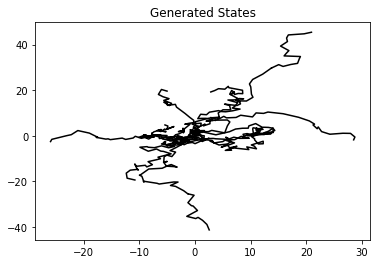

In [59]:
fig, ax = plt.subplots()

ax.plot(z_samples_prior[:10,..., 0].T, z_samples_prior[:10,..., 1].T, label="Gen. State", color="black", linestyle="-")
ax.set(title="Generated States")
plt.show()

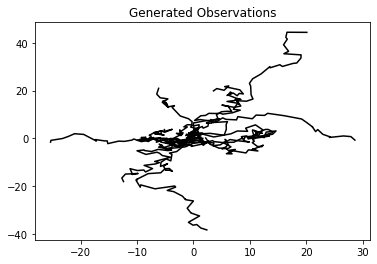

In [61]:
fig, ax = plt.subplots()

ax.plot(x_samples_prior[:10,..., 0].T, x_samples_prior[:10,..., 1].T, label="Gen. State", color="black", linestyle="-")
ax.set(title="Generated Observations")
plt.show()

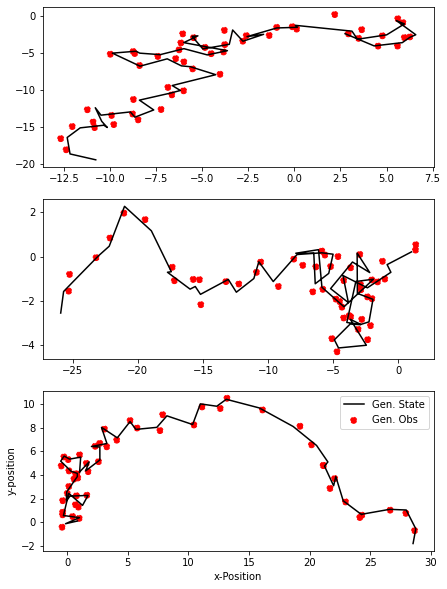

In [62]:
n_plots = 3
rand_int = 1

fig, axes = plt.subplots(nrows=3, figsize=(7, 10))

for i, iax in enumerate(axes):
    
    i += rand_int

    iax.plot(z_samples_prior[i, ..., 0], z_samples_prior[i, ..., 1], label="Gen. State", color="black", linestyle="-")
    iax.scatter(x_samples_prior[i,..., 0], x_samples_prior[i,..., 1], label="Gen. Obs", color="red", linestyle="--")

iax.set(xlabel="x-Position", ylabel="y-position", )

plt.legend()
plt.show()
    

## Training

In [63]:
from numpyro import diagnostics, infer, optim

In [64]:
# Inference
kernel = infer.NUTS(gaussian_hmm_unknown)
mcmc = infer.MCMC(kernel, num_warmup=200, num_samples=100)
mcmc.run(rng_key_infer, x_samples_proi)
posterior_samples = mcmc.get_samples()

sample: 100%|█| 300/300 [00:02<00:00, 103.68it/s, 15 steps of size 3.17e-01. acc


### Posterior

In [65]:
%%time
# Posterior prediction
predictive = infer.Predictive(gaussian_hmm_unknown, posterior_samples=posterior_samples, return_sites=["x", "z"], num_samples=100, )
posterior_predictive = predictive(rng_key_posterior, time_steps=50)


RuntimeError: Substituted value for site trans_noise requires length less than or equal to scan length. Expected length <= 50, but got 100.

In [41]:
# extract samples
x_samples_learned = posterior_predictive["x"]
z_samples_learned = posterior_predictive["z"]

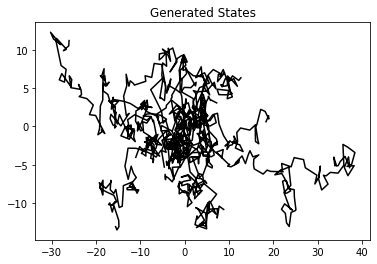

In [42]:
fig, ax = plt.subplots()

ax.plot(z_samples_learned[:10,..., 2].T, z_samples_learned[:10,...,3].T, label="Gen. State", color="black", linestyle="-")
ax.set(title="Generated States")
plt.show()

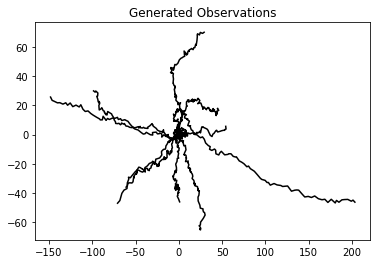

In [43]:
fig, ax = plt.subplots()

ax.plot(x_samples_learned[:10,..., 0].T, x_samples_learned[:10,..., 1].T, label="Gen. State", color="black", linestyle="-")
ax.set(title="Generated Observations")
plt.show()

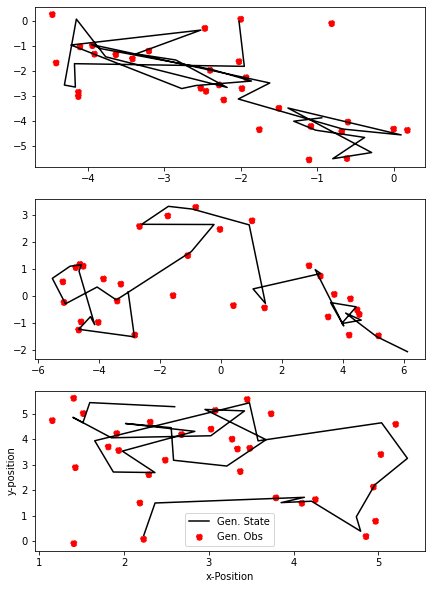

In [37]:

n_plots = 3
rand_int = 1

fig, axes = plt.subplots(nrows=3, figsize=(7, 10))

for i, iax in enumerate(axes):
    
    i += rand_int

    iax.plot(z_samples_learned[i, ..., 0], z_samples_learned[i, ..., 1], label="Gen. State", color="black", linestyle="-")
    iax.scatter(x_samples_learned[i,..., 0], x_samples_learned[i,..., 1], label="Gen. Obs", color="red", linestyle="--")

iax.set(xlabel="x-Position", ylabel="y-position", )

plt.legend()
plt.show()

In [22]:
x_lb, x_mu, x_ub = jnp.quantile(x_pred, jnp.array([0.05, 0.5, 0.95]), axis=0)

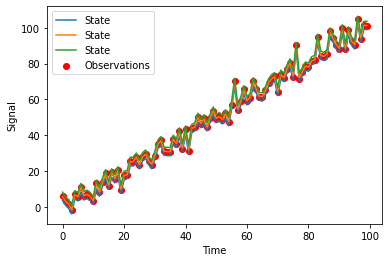

In [23]:
fig, ax = plt.subplots()

ax.plot(t_axes, x_lb, label="State")
ax.plot(t_axes, x_mu, label="State")
ax.plot(t_axes, x_ub, label="State")
ax.scatter(t_axes, obs, label="Observations", color="Red")

ax.set(xlabel="Time", ylabel="Signal", )

plt.legend()

In [24]:
%%time
# Posterior prediction
predictive = infer.Predictive(gaussian_hmm, posterior_samples=posterior_samples)
posterior_predictive = predictive(rng_key_posterior, time_steps=T)

CPU times: user 675 ms, sys: 4.14 ms, total: 680 ms
Wall time: 678 ms


In [25]:
posterior_predictive

{'x': DeviceArray([[  6.509223 ,   3.4477134,   3.0721214, ...,  94.66317  ,
               101.54628  , 103.5088   ],
              [  5.90064  ,   3.0008442,   3.7643754, ...,  94.31554  ,
               102.8232   , 101.03962  ],
              [  5.4269857,   6.404937 ,   1.7498865, ...,  95.78799  ,
               102.3584   , 102.26764  ],
              ...,
              [  7.088683 ,   2.0225248,   1.745909 , ...,  96.24111  ,
               101.640495 , 102.01367  ],
              [  5.4129624,   4.2352624,   1.944964 , ...,  94.893936 ,
               100.06557  , 101.062515 ],
              [  7.566144 ,   3.9211729,   1.772965 , ...,  92.98259  ,
               102.14805  ,  99.67388  ]], dtype=float32)}

In [26]:
with numpyro.handlers.seed(rng_seed=rng_key_prior):
    x, temp = gaussian_hmm(x_pred[0])

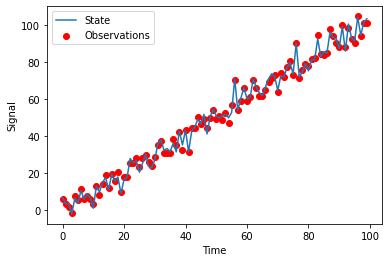

In [27]:
fig, ax = plt.subplots()

ax.plot(t_axes, temp, label="State")
ax.scatter(t_axes, obs, label="Observations", color="Red")

ax.set(xlabel="Time", ylabel="Signal", )

plt.legend()

## Training - SVI

In [28]:
from typing import Optional
from numpyro.distributions import constraints

def guide(
    x: Optional[jnp.ndarray] = None,
    time_steps: int=30
) -> None:

    if x is not None:
        time_steps = x.shape[0]

    phi = numpyro.param("phi", jnp.ones(1))
    sigma = numpyro.param("sigma", 0.05 * jnp.ones(1), constraint=constraints.positive)
    numpyro.sample("z", dist.Normal(x * phi, sigma))

In [29]:
from numpyro.infer.autoguide import AutoNormal, AutoDelta

In [39]:
%%time
# optimizers
lr = 1e-3
adam = optim.Adam(lr)


guide = AutoDelta(gaussian_hmm)
# def guide(x, time_steps=30):
#     return None

n_epochs = 100

# Inference
svi = infer.SVI(gaussian_hmm, guide, adam, infer.Trace_ELBO())
svi_result = svi.run(rng_key_infer, n_epochs, x)

100%|█| 100/100 [00:01<00:00, 72.42it/s, init loss: 1471.8112, avg. loss [96-100

CPU times: user 3.39 s, sys: 32 ms, total: 3.43 s
Wall time: 3.42 s


In [40]:
svi_result.params

{'emi_auto_loc': DeviceArray(-0.34366804, dtype=float32),
 'trans_auto_loc': DeviceArray(-0.17390238, dtype=float32),
 'z0_auto_loc': DeviceArray(0.16480985, dtype=float32),
 'z_auto_loc': DeviceArray([-0.29762158,  0.32173952, -0.31151786,  0.20227814,
               0.05726088, -0.03547774, -0.23314896, -0.05332242,
              -0.03780228, -0.22040537,  0.25432295, -0.12029181,
               0.46397302, -0.4715965 ,  0.13166323, -0.13449778,
               0.20718116,  0.37564853, -0.34094512,  0.21038872,
               0.08150647,  0.07732162, -0.41599554,  0.03959433,
              -0.30663377,  0.04491648,  0.6263176 , -0.06376899,
               0.00137994,  0.06768162,  0.20922709, -0.30935702,
               0.45932704,  0.04676234, -0.35031882,  0.04582974,
               0.09310818,  0.14440244, -0.08386963,  0.0608173 ,
              -0.15887427, -1.0145738 ,  0.67197275, -0.01141255,
              -0.5123433 , -0.04443106,  0.6225811 , -0.10729364,
              -0.239

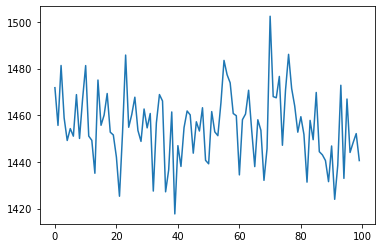

In [41]:
fig, ax = plt.subplots()

ax.plot(svi_result.losses)

plt.show()

In [42]:
# Posterior prediction
predictive = infer.Predictive(gaussian_hmm, params=svi_result.params, num_samples=10)
posterior_predictive = predictive(rng_key_posterior, time_steps=T)

#### Results - X

In [43]:
x_pred = posterior_predictive["x"]
x_lb, x_mu, x_ub = jnp.quantile(x_pred, jnp.array([0.05, 0.5, 0.95]), axis=0)

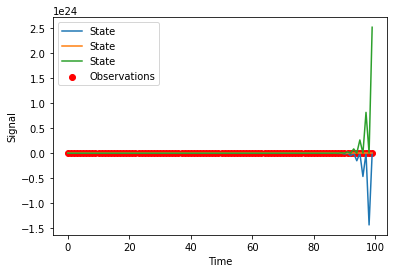

In [44]:
fig, ax = plt.subplots()

ax.plot(t_axes, x_lb, label="State")
ax.plot(t_axes, x_mu, label="State")
ax.plot(t_axes, x_ub, label="State")
ax.scatter(t_axes, obs, label="Observations", color="Red")

ax.set(xlabel="Time", ylabel="Signal", )

plt.legend()

In [ ]:
%%time
# optimizers
lr = 1e-2
adam = optim.Adam(lr)

# def guide(x=None, seq_len: int=0, batch:int=0, x_dim: int=1, future_steps=0, z_dim: int=2, ):
#     return None



n_epochs = 50_000

# Inference
svi = infer.SVI(kf_model, guide, adam, infer.Trace_ELBO())
svi_result = svi.run(rng_key_infer, n_epochs, x)

100%|█| 50000/50000 [00:08<00:00, 5901.65it/s, init loss: nan, avg. loss [47501-


CPU times: user 12.1 s, sys: 206 ms, total: 12.3 s
Wall time: 12.4 s


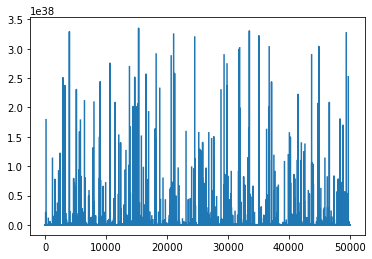

In [ ]:
plt.plot(svi_result.losses)

In [726]:
svi_result.params

{'phi': DeviceArray([[1.0124203]], dtype=float32),
 'sigma': DeviceArray([0.00953189], dtype=float32)}

In [731]:

# Posterior prediction
predictive = infer.Predictive(kf_model, params=svi_result.params, num_samples=20)
posterior_predictive = predictive(rng_key_posterior, None, *x.shape, future_steps=10)

In [732]:
x_pred.shape, x.shape

((20, 50, 10, 1), (50, 10, 1))

In [733]:
x_pred = posterior_predictive["x"]

lb, pred, ub = jnp.percentile(x_pred, jnp.array([0.1, 0.5, 0.95]), axis=0)

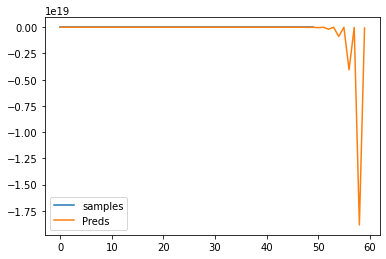

In [734]:
fig, ax = plt.subplots()

ax.plot(x[:, 0, :], label="samples")
ax.plot(pred[:, 0, :], label="Preds")

plt.legend()
plt.show()

In [710]:
x_pred.shape

(10, 50, 10, 1)

In [281]:
d = jnp.ones(2)
d = jnp.diag(d)
d

DeviceArray([[1., 0.],
             [0., 1.]], dtype=float32)

In [ ]:
# initialize Kalman Filter
state_dim = 2
observation_dim = 1

# init transition model
transition_matrix = jnp.array([[1., 1.], [0., 1.]])   # state transition matrix
transition_noise = 1e-4 * jnp.eye((state_dim))                # state uncertainty

# check sizes
assert transition_matrix.shape == (state_dim, state_dim)
assert transition_noise.shape == (state_dim, state_dim)

# init emission model
observation_matrix = jnp.array([[1., 0.]])             # emission matrix
observation_noise = 50. * jnp.eye((1))                  # emission uncertainty

assert observation_matrix.shape == (observation_dim, state_dim)
assert observation_noise.shape == (observation_dim, observation_dim)


# Prior parameter distribution
mu0 = jnp.array([2.0, 0.0]).astype(float)
Sigma0 = jnp.eye(state_dim) * 1.0

assert mu0.shape == (state_dim,)
assert Sigma0.shape == (state_dim, state_dim)

##

In [258]:


# initia
transition_noise_dist = lgssm.MultivariateNormal(jnp.zeros(state_dim), transition_noise)

observation_noise_dist = lgssm.MultivariateNormal(jnp.zeros(observation_dim), observation_noise)

initial_state_prior_dist = lgssm.MultivariateNormal(mu0, Sigma0)

kf_model = lgssm.LinearGaussianStateSpaceModel(
    transition_matrix, transition_noise_dist,
    observation_matrix, observation_noise_dist,
    initial_state_prior_dist
)

In [259]:
%%time

log_probs, mus, sigmas, mus_cond, sigmas_cond = kf_model.forward_filter(obs_samples[0])


mus.shape, sigmas.shape

CPU times: user 361 ms, sys: 6.23 ms, total: 367 ms
Wall time: 365 ms


((50, 2), (50, 2, 2))

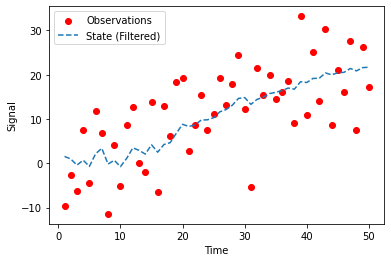

In [261]:
fig, ax = plt.subplots()


ax.scatter(ts[0], obs_samples[0], color="red", label="Observations")
ax.plot(ts[0], mus[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

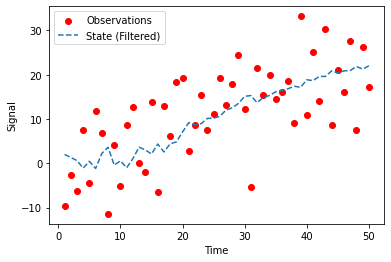

In [263]:
fig, ax = plt.subplots()


ax.scatter(ts[0], obs_samples[0], color="red", label="Observations")
ax.plot(ts[0], mus_cond[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

In [19]:
state.shape, obs.shape

((2,), (1,))

In [20]:
# initialize states
all_states, all_obs = [], []

state = state_init

for i_step in tqdm(sample_keys):
    
    # kalman step
    state, (state, obs) = kf_model.sample_step(state, i_step)
    
    # append
    all_states.append(state)
    all_obs.append(obs)
    

all_states = jnp.vstack(all_states)
all_obs = jnp.vstack(all_obs)

NameError: name 'sample_keys' is not defined

TypeError: list indices must be integers or slices, not tuple

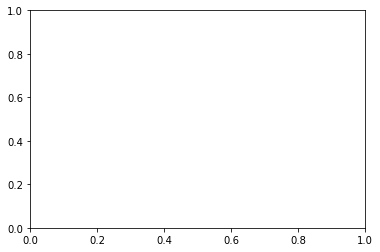

In [21]:
fig, ax = plt.subplots()

ax.plot(time_steps, all_states[:, 0], label="True State", color="green")
ax.scatter(time_steps, all_obs, label="Observations", color="red", alpha=0.4)

plt.legend()
plt.show()

In [112]:
num_time_steps = 100

all_states, all_obs = kf_model.sample(seed=123, sample_shape=10, num_timesteps=num_time_steps)
states.shape, all_obs.shape

((1, 100, 2), (10, 100, 1))

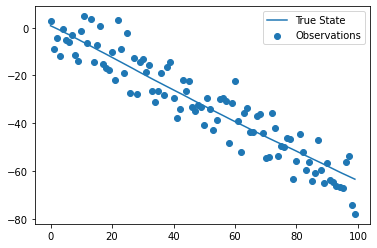

In [117]:
fig, ax = plt.subplots()

ax.plot(time_steps, all_states[3, :, 0], label="True State")
ax.scatter(time_steps, all_obs[3, :, 0], label="Observations")

plt.legend()
plt.show()

In [100]:
mu0.shape

(2,)

In [130]:
kf_model.sample_step(mu0, key)

(2,) (2, 1) (1,)


TypeError: dot_general requires contracting dimensions to have the same shape, got [1] and [2].

---

## Filtering

1. Do Forward Filter for a batch of inputs
2. Init prior mean, cov
3. Loop Through Kalman Step (mu0, cov0)

In [11]:
from jaxkf._src.functional.ops import kalman_step

In [14]:
num_time_steps = 15

states_preds, states_corrs = [], []

for i_t_step in trange(num_time_steps):
    
    # kalman step
    state_pred, state_corrected = kalman_step(
    
    pass

SyntaxError: invalid syntax (2776370347.py, line 12)

### Kalman Filter Step

### Predict Step

## Smoothing

### Posterior Marginals (Alternative)

## Log Probability

## Model

##### Initialize Parameters

In [12]:
kf_params = KFParams(
    F=F, R=R,
    H=H, Q=Q
)